In [1]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import os
import sys
import random
PATH = '/home/ubuntu/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

In [4]:
import pretty_midi
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [6]:
ls /home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid

/home/ubuntu/music-generation/data/avicii/avicii-you_make_me.mid


In [7]:
from pathlib import Path

In [8]:
pth = Path('/home/ubuntu/music-generation/data')

In [9]:
allsongs = list((pth/'edm_songs_lstm/train').iterdir())

In [10]:
len(allsongs)

176

In [11]:
allsongs[:2]

[PosixPath('/home/ubuntu/music-generation/data/edm_songs_lstm/train/pitbull-give_me_everything_feat_ne_yo_afrojack_nayer.mid'),
 PosixPath('/home/ubuntu/music-generation/data/edm_songs_lstm/train/CalvinHarrisExample_-_WellBeComingBack__iCarroller_20130206094707.mid')]

In [12]:
# shuf -n 10 -e * | xargs -i mv {} path-to-new-folder

In [13]:
path = '/home/ubuntu/music-generation/data'

In [14]:
# # removing midi files which can't be read or are not properly formatted
# for pa in allsongs:
#     fullpath = path+'/edm_songs_lstm/valid/'+pa.parts[-1]
#     try:
#         midi_data = midiread(fullpath, dt=0.3)
#     except: # also remove valuerror
#         os.remove(fullpath)

### DataLoader

In [15]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.T
    
    # Binarize the pressed notes 
    piano_roll[piano_roll > 0] = 1  # no need as unique values are 0 and 1
    
    return piano_roll

In [16]:
def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    """
    padding 0 at the beginning of sequence
    
    """
    # We hardcode 88 -- because we will always use only
    # 88 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll  # keep 0 padding at begin

    return padded_piano_roll

In [17]:
midi_folder_path = '/home/ubuntu/music-generation/data/edm_songs_lstm/valid'
midi_filenames = os.listdir(midi_folder_path)
midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in midi_full_filenames]

In [18]:
# stats of sequence lengths 
min(sequences_lengths), max(sequences_lengths), np.median(sequences_lengths), np.mean(sequences_lengths)

(24, 734, 27.0, 142.73333333333332)

In [19]:
piano_roll = midi_filename_to_piano_roll(midi_full_filenames[0])

In [20]:
piano_roll

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# making validation slices of sequence length 50

val_slices=[]

for k in range(len(midi_full_filenames)):
    piano_roll = midi_filename_to_piano_roll(midi_full_filenames[k])
    
    for i in range(piano_roll.shape[1]):
        if i%50 == 0:
            try:
                val_slices.append(piano_roll[:,i:i+51])
            except IndexError:
                pass
    

In [22]:
validation_list = [v for v in val_slices if v.shape[1] == 51]

In [23]:
len(validation_list)

34

In [30]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=50):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = [os.path.join(midi_folder_path, filename) for filename in midi_filenames]
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = [midi_filename_to_piano_roll(filename).shape[1] for filename in self.midi_full_filenames]
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # median length of songs
        if piano_roll.shape[1] > self.longest_sequence_length:
                random_strt_idx = np.random.randint(0, piano_roll.shape[1] -
                                                    self.longest_sequence_length+3, 1) # +3 just to make sure of gaps at the end
                ground_truth_sequence = piano_roll[:, 
                                            random_strt_idx[0] :
                                            random_strt_idx[0]+self.longest_sequence_length]
                input_sequence = piano_roll[:,random_strt_idx[0]-1 :
                                            random_strt_idx[0]+self.longest_sequence_length-1]

        else:
            input_sequence = piano_roll[:,:-1]
            ground_truth_sequence = piano_roll[:, 1:]        
        
        
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length) 
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([self.longest_sequence_length]) )

In [27]:
class Dataset_validation(data.Dataset):
    
    def __init__(self, val_list, longest_sequence_length=50):
        
        self.val_list = val_list
        self.longest_sequence_length = longest_sequence_length
    
    def __len__(self):
        
        return len(self.val_list)
    
    def __getitem__(self, index): 
        piano_roll = self.val_list[index]
        input_sequence = piano_roll[:,:-1]
        ground_truth_sequence = piano_roll[:, 1:]        
   
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length) 
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=0)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([self.longest_sequence_length]) )

In [28]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1) 
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [31]:
trainset = NotesGenerationDataset(os.path.join(PATH, 'data/edm_songs_lstm/train/'), longest_sequence_length=50)

trainset_loader = data.DataLoader(trainset, batch_size=10,
                                              shuffle=True, num_workers=4, drop_last=True)

In [32]:
len(trainset), len(trainset_loader)

(176, 17)

In [33]:
X = next(iter(trainset_loader))

In [34]:
input_sequences = X[0]

In [35]:
X[0].shape

torch.Size([10, 50, 88])

In [36]:
X[1].shape

torch.Size([10, 50, 88])

In [37]:
X[0][:3]

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [38]:
X[1][:3]

tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]]])

In [39]:
X[2][:5] # sequence length

tensor([[ 50],
        [ 50],
        [ 50],
        [ 50],
        [ 50]])

In [40]:
torch.sum(X[0])

tensor(1089.)

In [41]:
# valset = NotesGenerationDataset(os.path.join(PATH, 'data/edm_songs_lstm/valid/'),
#                                 longest_sequence_length=50, validation=True)
valset = Dataset_validation(validation_list)

valset_loader = data.DataLoader(valset, batch_size=5, shuffle=False, num_workers=4, drop_last=False)

In [42]:
len(valset)

34

In [43]:
X_val = next(iter(valset_loader))

In [44]:
X_val[0].shape

torch.Size([5, 50, 88])

In [45]:
torch.sum(X_val[0])

tensor(399.)

In [46]:
splitted_input_sequence_batch = X[0].split(split_size=1) 

In [47]:
splitted_input_sequence_batch

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0

### RNN

In [48]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout = 0.2)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [49]:
def validate(model):
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [50]:
len(trainset_loader)

17

In [51]:
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

In [52]:
# initial model loss without training
validate(model)

1.271905785218917

In [53]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [54]:
layers = list(model.children())

In [55]:
layers

[Linear(in_features=88, out_features=512, bias=True),
 BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 LSTM(512, 512, num_layers=2, dropout=0.2),
 Linear(in_features=512, out_features=88, bias=True)]

In [56]:
# def set_trainable_attr(m, b=True):
#     for p in m.parameters(): p.requires_grad = b

In [57]:
# def unfreeze_freeze(model_layer, b=True):
#     set_trainable_attr(model_layer,b)

In [58]:
# # tried it. freezing before and unfreezing doesn't work much
# # freezing all layers except last logits_fc on new data
# unfreeze_freeze(model.notes_encoder, False)
# unfreeze_freeze(model.bn, False)
# unfreeze_freeze(model.lstm, False)

### Training 

In [59]:
def lrfinder(start, end, model, trainset_loader, epochs=20):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))    
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters,start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

            optimizer.step()
        if epoch_number%5 == 0:
            print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25


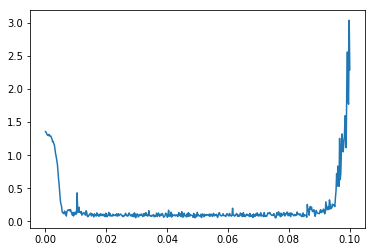

In [60]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = model.cuda()
lrs, losses = lrfinder(1e-4, 1e-1, rnn, trainset_loader, epochs=30)

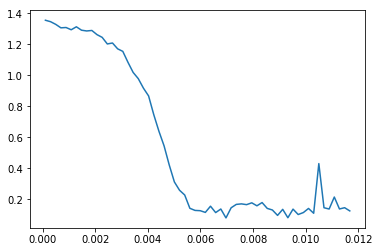

In [61]:
plt.plot(lrs[:60], losses[:60])

Training

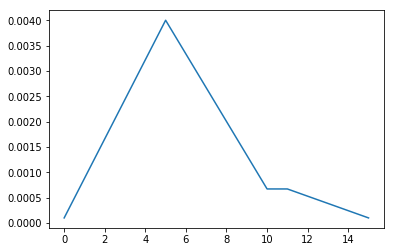

In [62]:
def get_triangular_lr(lr_low, lr_high, mini_batches, epochs_number = 1):
    iterations = mini_batches*epochs_number
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-4, 0.004, len(trainset_loader))
plt.plot(lrs_triangular)

In [63]:
len(lrs_triangular)

16

In [77]:
def train_model(model, lrs_triangular, epochs_number=10, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(parameters, lr=lrs_triangular[0], weight_decay=wd)
    ctr = 0
    
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        for batch in trainset_loader:
            try: 
                optimizer.param_groups[0]['lr'] = lrs_triangular[ctr]
            except IndexError: pass
            ctr+=1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        current_val_loss = validate(model)
        
#         if epoch_number%5 == 0:
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)   
#         if epoch_number%5 == 0:
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_edm_new.pth')
            best_val_loss = current_val_loss
    return best_val_loss

**IMP: Run load model chunks again as we did lrfinder and it would have changed some things**

In [78]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

In [79]:
lrs_triangular = get_triangular_lr(1e-3, 0.004, len(trainset_loader),epochs_number=11)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=11)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 1.2423019409179688
Validation Loss: Epoch: 0 : 1.134347583138369

Training Loss: Epoch: 1 : 0.7157239861348096
Validation Loss: Epoch: 1 : 0.2964660905644218

Training Loss: Epoch: 2 : 0.13272319208173192
Validation Loss: Epoch: 2 : 0.1952815507694999

Training Loss: Epoch: 3 : 0.1038902585997301
Validation Loss: Epoch: 3 : 0.44220299052682155

Training Loss: Epoch: 4 : 0.10483248926260892
Validation Loss: Epoch: 4 : 0.6220456634358289

Training Loss: Epoch: 5 : 0.09647026636144694
Validation Loss: Epoch: 5 : 0.42274658203125

Training Loss: Epoch: 6 : 0.08501023952575291
Validation Loss: Epoch: 6 : 0.3763867448612968

Training Loss: Epoch: 7 : 0.0772054329076234
Validation Loss: Epoch: 7 : 0.27413435176094586

Training Loss: Epoch: 8 : 0.0750261895796832
Validation Loss: Epoch: 8 : 0.40418277189693347

Training Loss: Epoch: 9 : 0.07389699799173019
Validation Loss: Epoch: 9 : 0.3859656251305565

Training Loss: Epoch: 10 : 0.0684605966157773
Validation Loss: Ep

Validation starts increasing after some point and training is still decreasing. Trying some weight decay

In [80]:
lrs_triangular = get_triangular_lr(1e-3, 0.004, len(trainset_loader),epochs_number=11)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=11, wd=1e-4)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.07067111945327591
Validation Loss: Epoch: 0 : 0.6960705370571524

Training Loss: Epoch: 1 : 0.07623696502517252
Validation Loss: Epoch: 1 : 0.3670041595295789

Training Loss: Epoch: 2 : 0.07814655431053218
Validation Loss: Epoch: 2 : 0.2169007963292739

Training Loss: Epoch: 3 : 0.086587275214055
Validation Loss: Epoch: 3 : 0.9115509979737634

Training Loss: Epoch: 4 : 0.08376246471615399
Validation Loss: Epoch: 4 : 0.3620937180136614

Training Loss: Epoch: 5 : 0.0743205334772082
Validation Loss: Epoch: 5 : 0.27338814964906416

Training Loss: Epoch: 6 : 0.06946806916419197
Validation Loss: Epoch: 6 : 0.24248495336522394

Training Loss: Epoch: 7 : 0.06825709233389181
Validation Loss: Epoch: 7 : 0.22688609240526822

Training Loss: Epoch: 8 : 0.0638327782644945
Validation Loss: Epoch: 8 : 0.1911338879590366

Training Loss: Epoch: 9 : 0.06548219765810405
Validation Loss: Epoch: 9 : 0.23310534472134023

Training Loss: Epoch: 10 : 0.06517493001678411
Validation Lo

In [81]:
best_val_loss

0.1659783478599181

Some more weight decay

In [82]:
lrs_triangular = get_triangular_lr(1e-4, 0.004, len(trainset_loader),epochs_number=10)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-3)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.0656921543619212
Validation Loss: Epoch: 0 : 0.14269547569560495

Training Loss: Epoch: 1 : 0.07931225724956568
Validation Loss: Epoch: 1 : 0.1556174611790295

Training Loss: Epoch: 2 : 0.08492791236323469
Validation Loss: Epoch: 2 : 0.20443658838935078

Training Loss: Epoch: 3 : 0.09603047590045367
Validation Loss: Epoch: 3 : 0.19819383917007855

Training Loss: Epoch: 4 : 0.0897797876421143
Validation Loss: Epoch: 4 : 0.15713495917498746

Training Loss: Epoch: 5 : 0.08320822785882388
Validation Loss: Epoch: 5 : 0.1405666175883084

Training Loss: Epoch: 6 : 0.08138782706330805
Validation Loss: Epoch: 6 : 0.12906745135465408

Training Loss: Epoch: 7 : 0.07894896387177355
Validation Loss: Epoch: 7 : 0.12585673531108998

Training Loss: Epoch: 8 : 0.07490144428961418
Validation Loss: Epoch: 8 : 0.129706041468656

Training Loss: Epoch: 9 : 0.07684165217420634
Validation Loss: Epoch: 9 : 0.12661329055214948



Weight decay is helping. Trying little higher weight decay for 5 epochs

In [84]:
lrs_triangular = get_triangular_lr(1e-4, 0.004, len(trainset_loader),epochs_number=5)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=5, wd=1e-2)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.09889538345091484
Validation Loss: Epoch: 0 : 0.228681013953877

Training Loss: Epoch: 1 : 0.1290092021226883
Validation Loss: Epoch: 1 : 0.1881249102424173

Training Loss: Epoch: 2 : 0.1258554559420137
Validation Loss: Epoch: 2 : 0.18250555844230448

Training Loss: Epoch: 3 : 0.12812820164596334
Validation Loss: Epoch: 3 : 0.1866668309502423

Training Loss: Epoch: 4 : 0.12549208762014613
Validation Loss: Epoch: 4 : 0.18539334873464655



1e-2 is not working good. Let's switch back to 1e-3 and train some more

In [109]:
lrs_triangular = get_triangular_lr(1e-4, 0.004, len(trainset_loader),epochs_number=10)
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=10, wd=1e-3)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training Loss: Epoch: 0 : 0.09035149282392334
Validation Loss: Epoch: 0 : 0.1609641963530352

Training Loss: Epoch: 1 : 0.09184182829716626
Validation Loss: Epoch: 1 : 0.1587315442090366

Training Loss: Epoch: 2 : 0.09340110640315448
Validation Loss: Epoch: 2 : 0.17417177496109418

Training Loss: Epoch: 3 : 0.08999447524547577
Validation Loss: Epoch: 3 : 0.15273236769405915

Training Loss: Epoch: 4 : 0.08921181892647463
Validation Loss: Epoch: 4 : 0.1631371539926784

Training Loss: Epoch: 5 : 0.09182971935061847
Validation Loss: Epoch: 5 : 0.15330639762674422

Training Loss: Epoch: 6 : 0.08864611562560587
Validation Loss: Epoch: 6 : 0.15491435739445814

Training Loss: Epoch: 7 : 0.08939593022360522
Validation Loss: Epoch: 7 : 0.15208676506491267

Training Loss: Epoch: 8 : 0.08912190794944763
Validation Loss: Epoch: 8 : 0.15545974241858498

Training Loss: Epoch: 9 : 0.0879225805401802
Validation Loss: Epoch: 9 : 0.15501684097045246



In [87]:
best_val_loss

0.15316293318641377

In [89]:
# rnn.load_state_dict(torch.load('music_edm_new.pth'))

Checking gradients of model

In [110]:
para = list(model.lstm.parameters())

In [112]:
p=para[0] 

In [113]:
p.grad

tensor(1.00000e-02 *
       [[ 0.0041, -0.0013, -0.0015,  ...,  0.0000,  0.0012, -0.0002],
        [-0.0006, -0.0048, -0.0006,  ...,  0.0000,  0.0001,  0.0006],
        [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0010,  0.0006, -0.0009,  ...,  0.0016,  0.0007,  0.0006],
        [-0.0035,  0.0029,  0.0011,  ...,  0.0012, -0.0003, -0.0000],
        [ 0.0013,  0.0006, -0.0006,  ..., -0.0013,  0.0004, -0.0009]], device='cuda:0')

### Validation

In [90]:
current_sequence_input = torch.zeros(1, 1, 88)
current_sequence_input[0, 0, 40] = 1
current_sequence_input[0, 0, 50] = 0
current_sequence_input[0, 0, 56] = 0
current_sequence_input = Variable(current_sequence_input.cuda())

In [91]:
current_sequence_input.data.squeeze(1)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]], device='cuda:0')

In [114]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    
    else:
        current_sequence_input = Variable(starting_sequence)
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None    

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


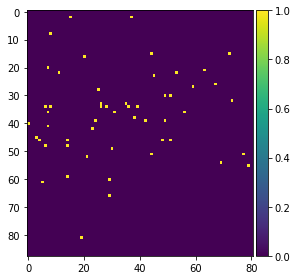

In [208]:
sample = sample_from_piano_rnn(sample_length=80, temperature=0.8).transpose()
io.imshow(sample)

In [209]:
midiwrite('sample.mid', sample.transpose(), dt=0.3)

In [210]:
FileLink('sample.mid')

/home/ubuntu/music-generation/sample.mid

Testloader

In [211]:
testset = NotesGenerationDataset('data/calvin_avicii/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=True, num_workers=4, drop_last=False)

In [212]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()

In [213]:
sample_orig = batch[0].numpy()

In [214]:
sample_orig.shape

(1, 75, 88)

In [215]:
# sample_orig = sample_orig[:,400:500,:]

In [216]:
sample_orig.shape

(1, 75, 88)

In [217]:
sample_orig = sample_orig.reshape((sample_orig.shape[1], sample_orig.shape[2]))

In [218]:
midiwrite('test0_orig.mid', sample_orig, dt=0.3)

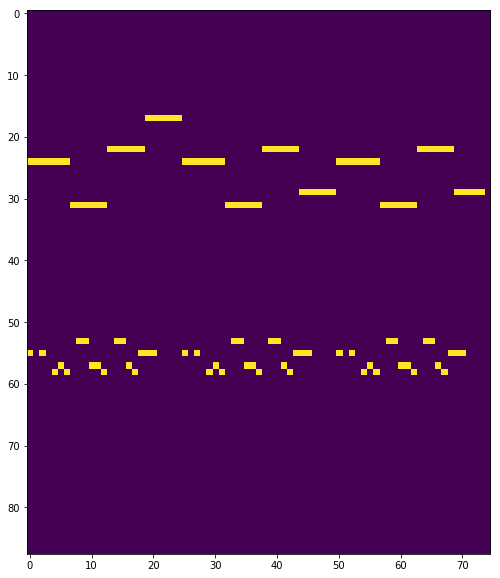

In [219]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(sample_orig.transpose())

In [199]:
FileLink('test0_orig.mid')

/home/ubuntu/music-generation/test0_orig.mid

In [200]:
input_sequences_batch_var.shape

torch.Size([75, 1, 88])

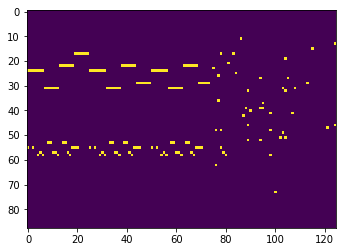

In [220]:
sample = sample_from_piano_rnn(sample_length=50, temperature=0.8, 
                               starting_sequence=input_sequences_batch_var).transpose()
plt.imshow(sample)

In [221]:
sample.shape

(88, 125)

In [230]:
midiwrite('test0.mid', sample.transpose(), dt=0.3)

In [231]:
FileLink('test0.mid')

/home/ubuntu/music-generation/test0.mid

### End